In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD #importing just to do truncatedSVD for me, I didn't have the time(and energy :) ) to implement by myself.

In [2]:
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20

C:\Users\Acer\Desktop\sem5\ell409\Assignment_1\Medical_MNIST


In [3]:
#data_loader
#!DEL *.npz
from tqdm import tqdm
split = 0.7 #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    X_test = []
    Y_test = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)
        random.shuffle(files)
        j=0
        for file in tqdm(files):
            if j < int(len(files)*split):
                X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y.append(i)
            else:
                X_test.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y_test.append(i)
            j += 1
        
        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3data.npz', X = np.array(X), Y = np.array(Y), X_test=X_test, Y_test = Y_test)
    return np.array(X), np.array(Y), np.array(X_test), np.array(Y_test)

if 'q3data.npz' in os.listdir('./'):
    zfile = np.load('q3data.npz')
    X = zfile['X']
    Y = zfile['Y']
    X_test = zfile['X_test']
    Y_test = zfile['Y_test']
else:
    X, Y, X_test, Y_test = data_loader()

In [4]:
print(f'X.shape = {X.shape}') #oof!
print(f'X_test.shape = {X_test.shape}')

X.shape = (41267, 4096)
X_test.shape = (17687, 4096)


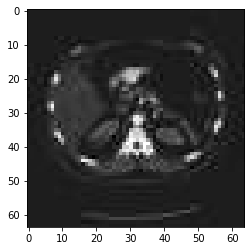

In [5]:
#Visualizing the images.
plt.imshow(X[0].reshape(64, -1), cmap='gray')

In [6]:
#Lets try to do PCA on the input images??
h, w = 64, 64
'''
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data
    #credits to https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184 for helping me write PCA
    #and saving me a few hours.
'''
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
'''
n_components = 50
P, C, M, X_centered=pca(X[:1000], n_pc=n_components)
#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 
'''

'\nn_components = 50\nP, C, M, X_centered=pca(X[:1000], n_pc=n_components)\n#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)\neigenscans = C.reshape((n_components, h, w))\neigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]\nplot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) \n'

In [7]:
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data

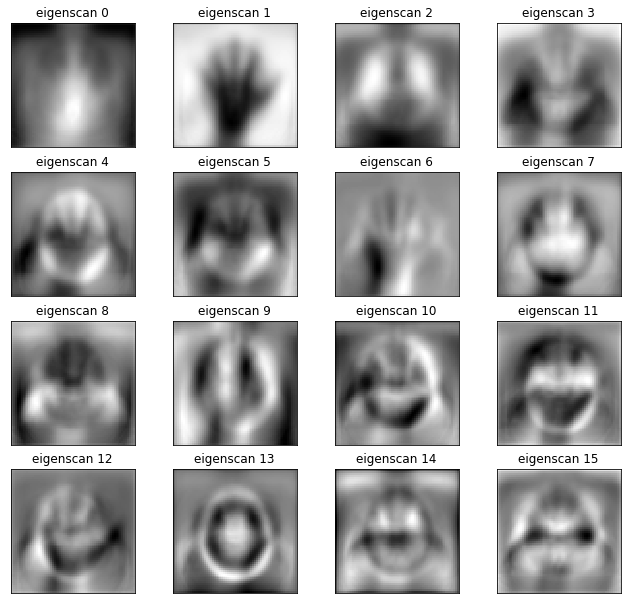

In [8]:

X_red, C, M, X_centered=fastpca(X, n_pc=n_components)
#X_red->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 

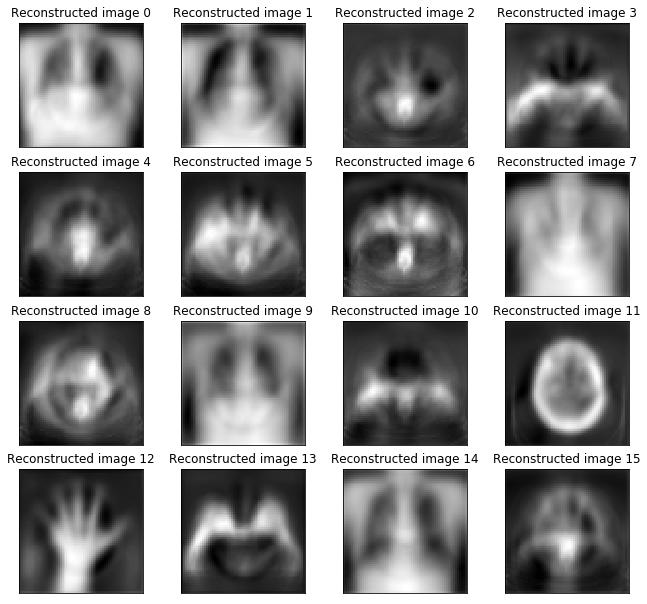

In [9]:
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image
arr = np.random.choice(X.shape[0], 16)
recovered_images=[reconstruction(X_centered, C, M, h, w, i) for i in arr]
plot_portraits(recovered_images, [f"Reconstructed image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

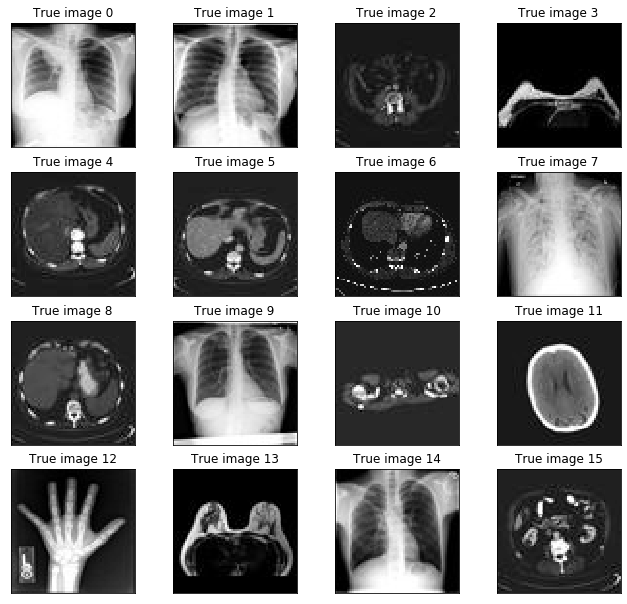

In [10]:
true_images = [X[i].reshape(h, w) for i in arr]
plot_portraits(true_images, [f"True image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

In [11]:
#looks good to me. Lets try to build a simple bayes classifier.
n_classes = 6
#we assume that the data is zero mean anyways(we centre the data anyways.)
#Assuming equal prior
P = np.ones(n_classes, dtype=np.float64)/n_classes
S = np.zeros((6, n_components, n_components) )
U = np.zeros((6, n_components))
for i in range(len(P)):
    S[i] = np.cov(X_red[[Y==i]], rowvar=False)
    U[i] = np.mean(X_red[[Y==i]], axis=0)        
def bayes(x, P):
    k = 0
    A = np.eye(n_components)*1e-3
    maxval = np.log(P[0]) - 0.5*np.log(np.linalg.det(S[0] @ A)) - 0.5*(x-U[0])@np.linalg.inv(S[0])@(x-U[0]).T
    for i in range(1, len(P)):
        testval = np.log(P[i]) - 0.5*np.log(np.linalg.det(S[i] @ A)) - 0.5*(x-U[i])@np.linalg.inv(S[i])@(x-U[i]).T
        if testval > maxval:
            k = i
            maxval = testval
    return k
            

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:32<00:00, 1277.47it/s]


[[6.978e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.267e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 7.000e+03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 6.960e+03 8.500e+01 0.000e+00]
 [2.200e+01 0.000e+00 0.000e+00 4.000e+01 6.911e+03 2.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 6.977e+03]]


Text(0, 0.5, 'Y_true')

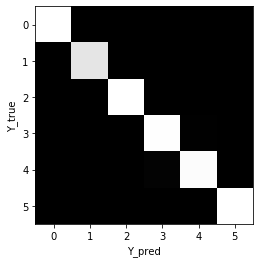

In [12]:
#evaluating our baye classifier on train data
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(len(X_red))):
    x = X_red[i]
    y = bayes(x, P)
    conf[y, Y[i]] += 1

print(conf)
plt.imshow(conf.T/np.sum(conf), cmap='gray')
plt.xlabel('Y_pred'); plt.ylabel('Y_true')

In [13]:
#lets evaluate on test data
C = C.reshape(n_components, -1);
conf = np.zeros((n_classes, n_classes))
P = np.ones(n_classes)/n_classes
Y_pred = []
for i in tqdm(range(X_test.shape[0])):
    x = X_test[i]
    x_red = (x) @ C.T
    y = bayes(x_red, P)
    conf[y, Y_test[i]] += 1
    Y_pred.append(y)

print(conf)
#plt.imshow(conf/np.sum(conf))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:17<00:00, 1009.35it/s]


[[3.000e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 2.599e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 2.990e+03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 2.990e+03 3.400e+01 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+01 1.000e+01 2.965e+03 5.000e+00]
 [0.000e+00 8.800e+01 0.000e+00 0.000e+00 1.000e+00 2.994e+03]]


([<matplotlib.axis.YTick at 0x20e29a8ce48>,
 <a list of 6 Text yticklabel objects>)

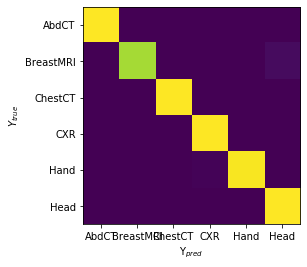

In [14]:
plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)



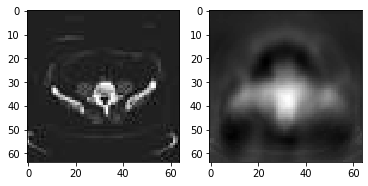

In [15]:
#lets attempt to reconstruct a test image
x = X_test[310]
x_red = (x - M)@ C.T

x_reconstructed = x_red @ C + M

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x.reshape(h, w), cmap='gray')
ax[1].imshow(x_reconstructed.reshape(h, w), cmap = 'gray')

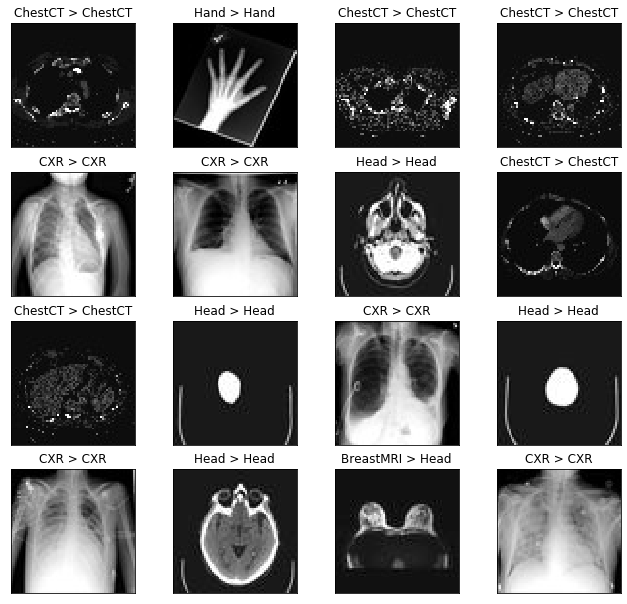

In [16]:
#works really well on train data but not on test data. Shuffling?
Y_pred = np.array(Y_pred)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
arr = np.random.choice(Y_pred.shape[0], 16)
true_images = [X_test[i].reshape(h, w) for i in arr]
plot_portraits(true_images, [f'{classes[Y_test[i]]} > {classes[Y_pred[i]]}' for i in arr], h, w, n_row=4, n_col=4)

In [17]:
import math

def Gauss(x, u, s):
    d = x.shape[0]


    try:
        a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
        S = np.abs(np.linalg.det(s))**(-0.5)
    except np.linalg.LinAlgError:
        print(s)
        print(np.linalg.det(s))
        
    return ((2*math.pi)**(-d/2))*S*a

def GMM(X, K):
    #Gaussian mixture model
    #X:data, K:number of components

    
    D = X.shape[1] #dimenionality of the data
    N = X.shape[0] #no of samples
    U = X[np.random.choice(N, K)] #initializing means as some K points in the data
    
    cov = np.cov(X, rowvar=False)

    #S = np.random.rand(K, D, D)*50 #variances
    S = np.stack([cov for k in range(K)], axis=0) #setting cov matrix of the data as guess for S
    #print(S)
    #print(np.linalg.det(S))
    #P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's, the contribution of each component
    P = np.ones(K)/K
    G = np.zeros((N,K))

    def gamma(n, k):
        sum = 0;
        for j in range(K):
            sum += P[j]*Gauss(X[n], U[j, :], S[j, :, :]);
            #print('sum = ', sum);
        return P[k]*Gauss(X[n], U[k, :], S[k, :, :])/sum;

    l_old = -1
    thresh = 1e-3
    iterations = 0
    loss_hist = []

    while(True):
        #E_step
        #print('iter = {}, l = {}'.format(iterations, l_old))
        for i in range(N):
            for j in range(K):
                #G[i, j] = gamma(i, j)
                G[i, j] = P[j]*Gauss(X[i], U[j, :], S[j, :, :])
        G = G/np.sum(G, axis=1)[:, np.newaxis]

        #M step
        N_k = np.sum(G, axis = 0)
        #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
        U = (G.T @ X)/(N_k[:, np.newaxis])
        for k in range(K): #improve by using broadcasting!
            #print((X_train - U[k,:]).shape)
            #print(G[:, k].shape)
            S[k, :] = ((X - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X - U[k, :])))/N_k[k]
        P = N_k/N

        #computing likelihood
        l = 0
        for i in range(N):
            s = 0
            for j in range(K):
                s += P[j]*Gauss(X[i], U[j, :], S[j, :, :])
                #print(s)
            l += np.log(s)
        #input()
        loss_hist.append(l)
        if np.abs(l - l_old) < thresh and iterations != 0:
            break;
        iterations += 1
        l_old = l
    print('Done.')
    return P, U, S, loss_hist

#function to evaluate p(x) given parameters of GMM
def calc_p_gmm(x, a):
    #x: input point, a:parameters, returned from function GMM
    P = a[0]
    U = a[1]
    S = a[2]
    K = P.shape[0]
    sum = 0
    for k in range(K):
        sum += P[k]*Gauss(x, U[k, :], S[k, :, :])
    return sum

In [19]:
a = []
K = 2
for i in range(n_classes):
    a.append(GMM(X_red[Y==i], K))

Done.
Done.
Done.
Done.
Done.
Done.


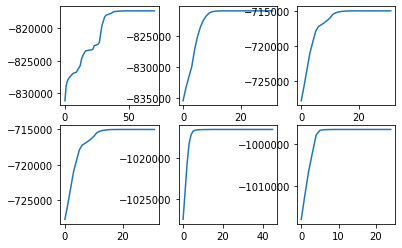

In [20]:
fig, ax = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        ax[i][j].plot(a[2*i + j][3])

In [21]:
def bayes_gmm(x, a, P):
    #P->prior
    maxval = P[0]*calc_p_gmm(x, a[0])
    k = 0
    for i in range(1, n_classes):
        tempval = P[i]*calc_p_gmm(x, a[i])
        if tempval > maxval:
            k = i
            maxval = tempval
    return k


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:25<00:00, 1617.31it/s]


[[6.981e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.267e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 7.000e+03 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 6.963e+03 2.400e+01 5.000e+00]
 [1.800e+01 0.000e+00 0.000e+00 3.700e+01 6.976e+03 6.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.931e+03]]


Text(0, 0.5, 'Y_true')

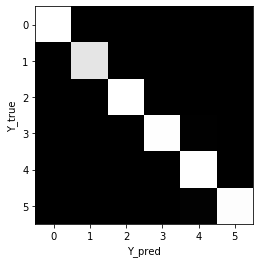

In [22]:
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(len(X_red))):
    x = X_red[i]
    y = bayes_gmm(x, a, P)
    conf[y, Y[i]] += 1

print(conf)
plt.imshow(conf.T/np.sum(conf), cmap='gray')
plt.xlabel('Y_pred'); plt.ylabel('Y_true')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:17<00:00, 1002.05it/s]


([<matplotlib.axis.YTick at 0x20e801f0f88>,
 <a list of 6 Text yticklabel objects>)

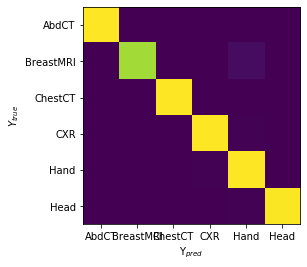

In [23]:
C = C.reshape(n_components, -1);
conf = np.zeros((n_classes, n_classes))
P = np.ones(n_classes)/n_classes
Y_pred = []
for i in tqdm(range(X_test.shape[0])):
    x = X_test[i]
    x_red = (x) @ C.T
    y = bayes_gmm(x_red,a, P)
    conf[y, Y_test[i]] += 1
    Y_pred.append(y)

plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)

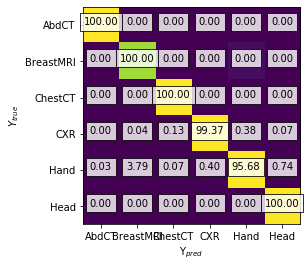

In [24]:
plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float((conf[i][j]/np.sum(conf[j]))*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [ ]:
#GMM with 3 components?
a = []
K = 2
for i in range(n_classes):
    a.append(GMM(X_red[Y==i], K))
fig, ax = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        ax[i][j].plot(a[2*i + j][3])

In [ ]:
def bayes_gmm(x, a, P):
    #P->prior
    maxval = P[0]*calc_p_gmm(x, a[0])
    k = 0
    for i in range(1, n_classes):
        tempval = P[i]*calc_p_gmm(x, a[i])
        if tempval > maxval:
            k = i
            maxval = tempval
    return k

conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(len(X_red))):
    x = X_red[i]
    y = bayes_gmm(x, a, P)
    conf[y, Y[i]] += 1

print(conf)
plt.imshow(conf.T/np.sum(conf), cmap='gray')
plt.xlabel('Y_pred'); plt.ylabel('Y_true')


In [ ]:
C = C.reshape(n_components, -1);
conf = np.zeros((n_classes, n_classes))
P = np.ones(n_classes)/n_classes
Y_pred = []
for i in tqdm(range(X_test.shape[0])):
    x = X_test[i]
    x_red = (x) @ C.T
    y = bayes_gmm(x_red,a, P)
    conf[y, Y_test[i]] += 1
    Y_pred.append(y)

plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float((conf[i][j]/np.sum(conf[j]))*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [34]:
#Linear Models for #Q3
X_red = np.concatenate((np.ones((X_red.shape[0], 1)), X_red), axis = 1)
Y_onehot = np.zeros((Y.size, n_classes))
Y_onehot[np.arange(Y.size),Y] = 1
W = np.linalg.inv((X_red.T) @ X_red)@X_red.T @ Y_onehot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:00<00:00, 617576.61it/s]


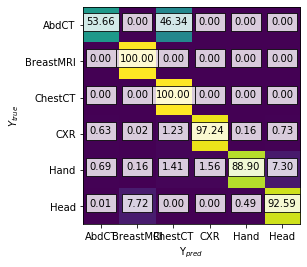

In [40]:
#computing accuracy on train data
Y_pred = X_red @ W
Y_pred = np.argmax(Y_pred, axis = 1)
assert(Y_pred.shape[0] == X_red.shape[0])
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(Y_pred.shape[0])):
    conf[Y_pred[i], Y[i]] += 1

conf = conf.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:00<00:00, 591117.50it/s]


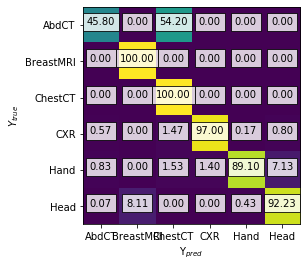

In [43]:
#On test data?
Y_pred = np.concatenate((np.ones( (X_test.shape[0], 1)), X_test @ C.T), axis = 1) @ W
Y_pred = np.argmax(Y_pred, axis = 1)
assert(Y_pred.shape[0] == X_test.shape[0])
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(Y_pred.shape[0])):
    conf[Y_pred[i], Y_test[i]] += 1
conf = conf.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [101]:
#with regularization and gradient descent??
#lets try l2 regularization
#we need to implement bath gradient descent for that.

def gradient_mse(X, Y, lr = 1e-9, l1_reg = 0, l2_reg = 0, n_iter=10000, batch_size=200):
    costs = []
    m = X.shape[0]
    W = np.random.rand(X.shape[1], n_classes)
    for i in tqdm(range(n_iter)):
        batch = np.random.choice(range(m), batch_size)
        X_batch = X[batch,:]
        Y_batch = Y[batch]
        
        #print(f'X_batch.shape = {X_batch.shape}')
        Y_onehot = np.zeros((Y_batch.size, n_classes))
        Y_onehot[np.arange(Y_batch.size),Y_batch] = 1
        #print(f'Y_onehot.shape = {Y_onehot.shape}')
        
        grad = 2*(X_batch.T/batch_size) @ (X_batch @ W - Y_onehot) + l1_reg*np.sign(W) + l2_reg*W
        costs.append(np.trace((X_batch @ W - Y_onehot).T @(X_batch @ W - Y_onehot))/batch_size + l1_reg*np.sum(np.abs(W)) + 0.5*l2_reg*np.sum(W*W))
        assert(grad.shape == W.shape), f'grad.shape = {grad.shape}, W.shape = {W.shape}'
        W -= lr*grad
    return W, costs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 99.05it/s]


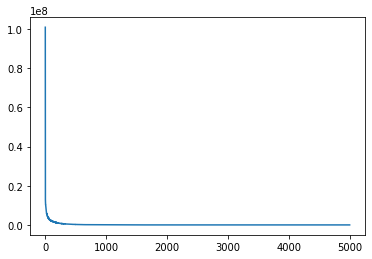

In [105]:
W_reg, costs = gradient_mse(X_red, Y, lr=1e-8, batch_size = 1000, n_iter=5000)
plt.plot(costs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:00<00:00, 712908.51it/s]


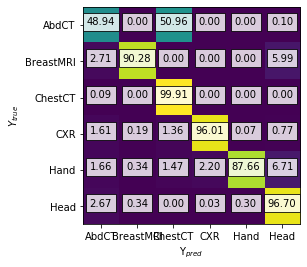

In [106]:
#getting accuracy now.
Y_pred = X_red @ W_reg
Y_pred = np.argmax(Y_pred, axis = 1)
assert(Y_pred.shape[0] == X_red.shape[0])
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(Y_pred.shape[0])):
    conf[Y_pred[i], Y[i]] += 1

conf = conf.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:00<00:00, 656821.06it/s]


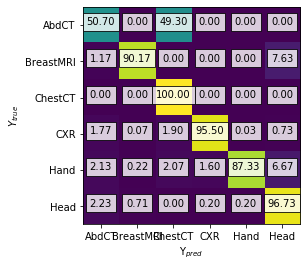

In [107]:
#on test data.
#On test data?
Y_pred = np.concatenate((np.ones( (X_test.shape[0], 1)), X_test @ C.T), axis = 1) @ W_reg
Y_pred = np.argmax(Y_pred, axis = 1)
assert(Y_pred.shape[0] == X_test.shape[0])
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(Y_pred.shape[0])):
    conf[Y_pred[i], Y_test[i]] += 1
conf = conf.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 155.41it/s]


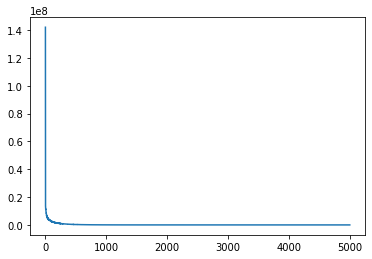

In [108]:
#now lets do regularization
W_reg, costs = gradient_mse(X_red, Y, lr=1e-8, l1_reg = 1e-3, l2_reg=0.1, batch_size = 1000, n_iter=5000)
plt.plot(costs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:00<00:00, 566827.17it/s]


Text(0.5, 1.0, 'elastic net reg with mse loss, on test data')

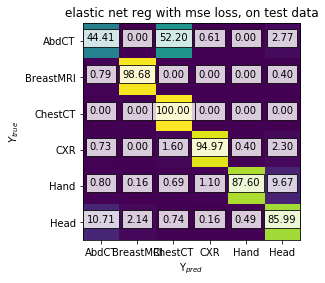

In [111]:
#getting accuracy now on train data
Y_pred = X_red @ W_reg
Y_pred = np.argmax(Y_pred, axis = 1)
assert(Y_pred.shape[0] == X_red.shape[0])
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(Y_pred.shape[0])):
    conf[Y_pred[i], Y[i]] += 1

conf = conf.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))
plt.title('elastic net reg with mse loss, on test data')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:00<00:00, 572063.75it/s]


Text(0.5, 1.0, 'elastic net reg with mse loss, on test data')

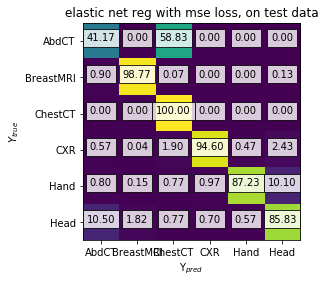

In [112]:

#On test data?
Y_pred = np.concatenate((np.ones( (X_test.shape[0], 1)), X_test @ C.T), axis = 1) @ W_reg
Y_pred = np.argmax(Y_pred, axis = 1)
assert(Y_pred.shape[0] == X_test.shape[0])
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(Y_pred.shape[0])):
    conf[Y_pred[i], Y_test[i]] += 1
conf = conf.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

plt.title('elastic net reg with mse loss, on test data')